# Explore 2023 hackweek model predictions
This ResDepth CNN was trained during the 2023 GeoSMART Hackweek. This version has been retrained on an updated dataset. 

In [1]:
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
import torch
from glob import glob
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import crunchy_snow.models
import crunchy_snow.dataset

In [2]:
# grab data paths
val_data_dir = '/home/jovyan/shared-public/crunchy-snow/data/subsets_v2/val'
val_path_list = glob(f'{val_data_dir}/ASO_50M_SD*.nc')

In [3]:
# define data to be returned by dataloader
selected_channels = ['aso_sd', # ASO lidar snow depth (target dataset)
                     'snowon_vv', # snow on Sentinel-1 VV polarization backscatter
                     'snowon_vh', # snow on Sentinel-1 VH polarization backscatter
                     'snowoff_vv', # snow off Sentinel-1 VV polarization backscatter
                     'snowoff_vh', # snow off Sentinel-1 VH polarization backscatter
                     'blue', # snow on Sentinel-2 blue band
                     'green', # snow on Sentinel-2 green band
                     'red', # snow on Sentinel-2 red band
                     'fcf', # fractional forest cover
                     'elevation', # elevation (COP30 DEM)
                     'aso_gap_map', # gaps in ASO data
                     'rtc_gap_map', # gaps in Sentinel-1 data
                     'ndvi', # Normalized Difference Vegetation Index from Sentinel-2
                     'ndsi', # Normalized Difference Snow Index from Sentinel-2
                     'ndwi', # Normalized Difference Water Index from Sentinel-2
                     'snowon_cr', # cross ratio, snowon_vh - snowon_vv
                     'snowoff_cr', # cross ratio, snowoff_vh - snowoff_vv
                    ]

# prepare validation dataloaders
val_data = crunchy_snow.dataset.Dataset(val_path_list, selected_channels, norm=True)
val_loader = torch.utils.data.DataLoader(dataset=val_data, batch_size=1, shuffle=True)

In [4]:
# define input channels for model
input_channels = [
    'snowon_vv',
    'snowon_vh',
    'snowoff_vv',
    'snowoff_vh',
    'blue',
    'green',
    'red',
    'fcf',
    'elevation',
    'ndvi',
    'ndsi',
    'ndwi',
    'snowon_cr',
    'snowoff_cr']

In [5]:
#load previous model
model = crunchy_snow.models.ResDepth(n_input_channels=len(input_channels))
model.load_state_dict(torch.load('../../weights/quinn_ResDepth_v3'))
model.to('cuda');    # to gpu memory from cpu 

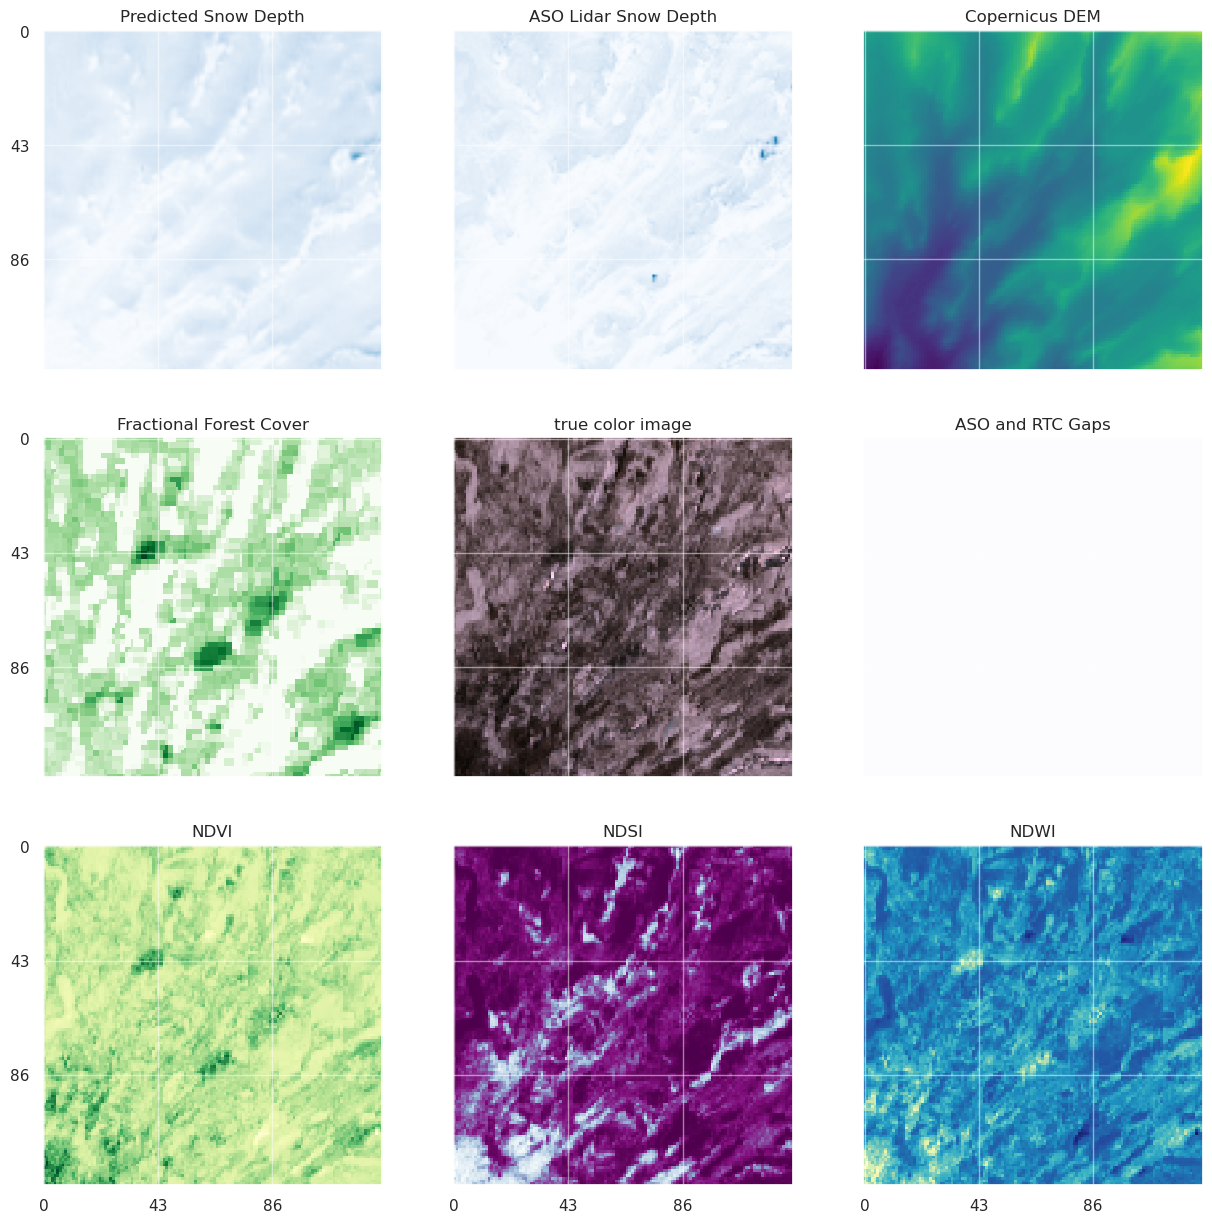

In [6]:
# visualize model predictions
sns.set_theme()
num_samples = 1

for i, data_tuple in enumerate(val_loader):
    if i < num_samples:
        # read data into dictionary
        data_dict = {name: tensor for name, tensor in zip(selected_channels, data_tuple)}

        with torch.no_grad():
            # Concatenate input feature channels, make prediction
            inputs = torch.cat([data_dict[channel] for channel in input_channels], dim=1).to('cuda')
            pred_sd = model(inputs)  # Generate predictions using the model
            pred_sd = pred_sd.to('cpu')
        
        f, ax = plt.subplots(3, 3, figsize=(15, 15), sharex=True, sharey=True)
        ax[0, 0].imshow(pred_sd.squeeze(), cmap='Blues', vmin=0, vmax=0.4, interpolation=None)
        ax[0, 0].set_title('Predicted Snow Depth')
        ax[0, 1].imshow(data_dict['aso_sd'].squeeze(), cmap='Blues', vmin=0, vmax=0.4, interpolation=None)
        ax[0, 1].set_title('ASO Lidar Snow Depth')
        ax[0, 2].imshow(data_dict['elevation'].squeeze(), cmap='viridis', interpolation='none')
        ax[0, 2].set_title('Copernicus DEM')
        ax[1, 0].imshow(data_dict['fcf'].squeeze(), cmap='Greens', interpolation='none')
        ax[1, 0].set_title('Fractional Forest Cover')
        norm_max = np.max([data_dict['green'].max(), data_dict['red'].max(), data_dict['blue'].max()]) # there are better ways to do this
        ax[1, 1].imshow(torch.cat((data_dict['red'].squeeze()[:, :, None]/norm_max, data_dict['green'].squeeze()[:, :, None]/norm_max, data_dict['blue'].squeeze()[:, :, None]/norm_max), 2).squeeze(), interpolation='none')
        ax[1, 1].set_title('true color image')
        ax[1, 2].imshow(data_dict['aso_gap_map'].squeeze() + data_dict['rtc_gap_map'].squeeze(), cmap='Purples', interpolation='none')
        ax[1, 2].set_title('ASO and RTC Gaps')
        ax[2, 0].imshow(data_dict['ndvi'].squeeze(), cmap='YlGn', interpolation='none')
        ax[2, 0].set_title('NDVI')
        ax[2, 1].imshow(data_dict['ndsi'].squeeze(), cmap='BuPu', interpolation='none')
        ax[2, 1].set_title('NDSI')
        ax[2, 2].imshow(data_dict['ndwi'].squeeze(), cmap='YlGnBu', interpolation='none')
        ax[2, 2].set_title('NDWI')
        
        # modify plot style
        for a in ax.flat:
            a.set_aspect('equal')
            a.set_xticks(np.arange(0, data_dict['aso_sd'].squeeze().shape[1], 43))
            a.set_yticks(np.arange(0, data_dict['aso_sd'].squeeze().shape[0], 43))
            a.grid(True, linewidth=1, alpha=0.5)
        
        # f.tight_layout()
    else:
        break

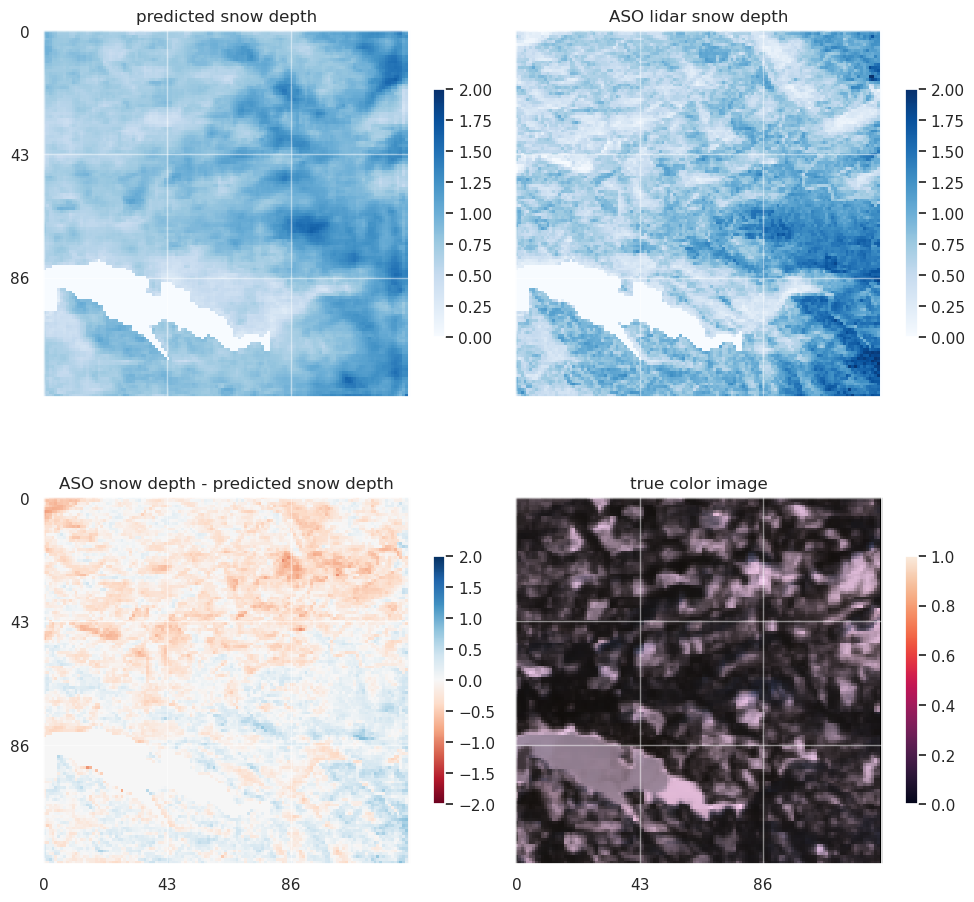

In [7]:
# visualize prediction error
sns.set_theme()
num_samples = 1
norm_dict = crunchy_snow.dataset.norm_dict

for i, data_tuple in enumerate(val_loader):
    if i < num_samples:
        # read data into dictionary
        data_dict = {name: tensor for name, tensor in zip(selected_channels, data_tuple)}

        with torch.no_grad():
            # Concatenate input feature channels, make prediction
            inputs = torch.cat([data_dict[channel] for channel in input_channels], dim=1).to('cuda')
            pred_sd = model(inputs)  # Generate predictions using the model
            pred_sd = pred_sd.to('cpu')

            # mask nodata areas
            pred_sd = torch.where(data_dict['aso_gap_map']+data_dict['rtc_gap_map'] == 0, pred_sd, torch.zeros_like(pred_sd))
            aso_sd = torch.where(data_dict['aso_gap_map']+data_dict['rtc_gap_map'] == 0, data_dict['aso_sd'], torch.zeros_like(pred_sd))

            # undo normalization
            pred_sd = crunchy_snow.dataset.undo_norm(pred_sd, crunchy_snow.dataset.norm_dict['aso_sd']).squeeze()
            aso_sd = crunchy_snow.dataset.undo_norm(aso_sd, crunchy_snow.dataset.norm_dict['aso_sd']).squeeze()
            
            # mask values above 0
            pred_sd = torch.where(pred_sd >= 0, pred_sd, torch.zeros_like(pred_sd))
            
            f, ax = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)
            im0 = ax[0, 0].imshow(pred_sd, cmap='Blues', vmin=0, vmax=2, interpolation='none') 
            ax[0, 0].set_title('predicted snow depth')
            f.colorbar(im0, shrink=0.5)
            im1 = ax[0, 1].imshow(aso_sd, cmap='Blues', vmin=0, vmax=2, interpolation='none')
            ax[0, 1].set_title('ASO lidar snow depth')
            f.colorbar(im1, shrink=0.5)

            im2 = ax[1, 0].imshow(aso_sd-pred_sd, cmap='RdBu', vmin=-2, vmax=2, interpolation='none') 
            ax[1, 0].set_title('ASO snow depth - predicted snow depth')
            f.colorbar(im2, shrink=0.5)
            norm_max = np.max([data_dict['green'].max(), data_dict['red'].max(), data_dict['blue'].max()]) # there are better ways to do this
            im3 = ax[1, 1].imshow(torch.cat((data_dict['red'].squeeze()[:, :, None]/norm_max, data_dict['green'].squeeze()[:, :, None]/norm_max, data_dict['blue'].squeeze()[:, :, None]/norm_max), 2).squeeze(), interpolation='none')
            ax[1, 1].set_title('true color image')
            f.colorbar(im3, shrink=0.5)

            # Set modify plot style
            for a in ax.flat:
                a.set_aspect('equal')
                a.set_xticks(np.arange(0, data_dict['aso_sd'].squeeze().shape[1], 43))
                a.set_yticks(np.arange(0, data_dict['aso_sd'].squeeze().shape[0], 43))
                a.grid(True, linewidth=1, alpha=0.5)

            plt.tight_layout()
    else: 
        break

loop 500/2750
loop 1000/2750
loop 1500/2750
loop 2000/2750
loop 2500/2750
plotting


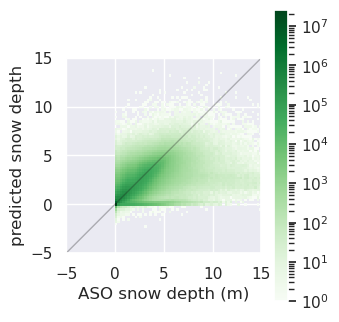

In [12]:
# scatterplot of predicted values vs target values for entire dataset
# **CAUTION: this plot can take a long time to run**

from matplotlib.colors import LogNorm

def plot_rmse(value_list, target_list, binwidth=0.25, axmin=-5, axmax=15):
    '''
    Plot binned values of two lists agains one another on a log scale
    '''
    sns.set_theme()
    
    f, ax = plt.subplots(1, 1, figsize=(3.5,3.5))

    sns.histplot(ax=ax, x=target_list, y=value_list, 
                 cmap='Greens', cbar=True, alpha=1, binwidth=binwidth, vmin=None, vmax=None, norm=LogNorm())
    ax.plot([-15, 15], [-15, 15], color='k', linestyle='-', linewidth=1, alpha=0.3)
    ax.set_xlabel('ASO snow depth (m)')
    ax.set_ylabel('predicted snow depth')
    ax.set_box_aspect(1)
    ax.set_xlim(axmin, axmax)
    ax.set_ylim(axmin, axmax)
    ax.set_xticks([-5, 0,5,10,15])
    ax.set_yticks([-5, 0,5,10,15])
    f.tight_layout()

def list_plot(data, data_loader, norm_dict):
    # init lists
    pred_array = np.array([])
    target_array = np.array([])

    for i, data_tuple in enumerate(data_loader):
        if (i+1)%500 == 0:
            print(f'loop {i+1}/{data.filelength}')

        data_dict = {name: tensor for name, tensor in zip(selected_channels, data_tuple)}
        inputs = torch.cat([data_dict[channel] for channel in input_channels], dim=1).to('cuda')
        
        with torch.no_grad():
            pred_sd = model(inputs)

        # undo normalization
        aso_sd = crunchy_snow.dataset.undo_norm(data_dict['aso_sd'], norm_dict['aso_sd'])
        pred_sd = crunchy_snow.dataset.undo_norm(pred_sd.squeeze().to('cpu'), norm_dict['aso_sd'])

        # mask missing values
        pred_sd = torch.where(data_dict['aso_gap_map']+data_dict['rtc_gap_map'] == 0, pred_sd, torch.zeros_like(pred_sd)).squeeze()
        aso_sd = torch.where(data_dict['aso_gap_map']+data_dict['rtc_gap_map'] == 0, aso_sd, torch.zeros_like(pred_sd)).squeeze()

        # convert to 1d lists for plotting
        pred_array = np.append(pred_array, pred_sd)
        target_array = np.append(target_array, aso_sd)
    
    print('plotting')
    plot_rmse(pred_array, target_array)

list_plot(val_data, val_loader, crunchy_snow.dataset.norm_dict)